In [1]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from ref_trajectory import generate_trajectory as traj
# %matplotlib notebook

There are a lot of configuration parameters. It is a good idea to separate it from the main code. At some point you will be doing parameter tuning. 

We will use toml format to store parameters. Open config.toml and go over the description of the different parameters we may use here

Read the config parameters, default output is a dictionary. You have to then store them as local variables. 
You have 2 options for this
1. update locals() directly - a little bit dangerous
2. You can use itemgetter

In [2]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)
print(dt, V_MAX)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.3, 'pred_horizon': 10, 'w_cte': 1.0, 'w_obs': 1.0, 'w_speed': 1.0}
0.1 1.2


There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable $(v, \omega)$ in that time instant given current $(v, \omega)$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. Let us integrate these pieces, make sure DWA works for a few paths!

In [3]:
v_min, v_max = 0.0, 0.2
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=11)
ws = np.linspace(w_min, w_max, num=11)
cmd = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
# print(vs)
# print(cmd)

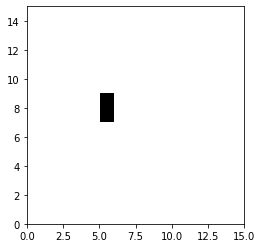

In [4]:
#choose resolution and dimensions
grid_res = 1
grid_span =  15 # square circuit dimensions in m

#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
grid_data = np.zeros(grid_shape)

#Create rectangular obstacles in world co-ordinates
#xmin, xmax, ymin, ymax
obstacles = np.array([[5,6,7,9]])#[[25, 26, 10, 40],
                      # [2, 8, 16, 20]]) 
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax ] = 1.0

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

#imshow() from prior cell
plt.figure()
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
plt.show()

w=0.8
l=1.2
mule_extents = np.array([[-w/2,-l/2],
                         [w/2, -l/2],
                         [w/2, l/2],
                         [-w/2, l/2],
                         [-w/2,-l/2]])

                        
r = 0.5
l = 0.4
circles = [(0, 0, r), (0, l, r), (0, -l, r)]

def circle_collision_check(grid, local_traj,grid_res=grid_res):
    xmax, ymax = grid.shape
    all_x = np.arange(xmax)
    all_y = np.arange(ymax)
    X, Y = np.meshgrid(all_x, all_y)
    
    occupied_pt = grid[X,Y] == 1
    
    min_distance_2 = np.inf
    x, y, t = local_traj[:,0], local_traj[:,1], local_traj[:,2]
    rot = np.array([[np.sin(t),-np.cos(t)],[np.cos(t),np.sin(t)]])
    rot = rot.transpose(2,0,1)
    n = local_traj.shape[0]
    for xc, yc, rc in circles:
        xy_rot = rot @ np.array([xc, yc]) + np.array([x, y]).T
        xc_rot,yc_rot = xy_rot[:,0],xy_rot[:,1]
        xc_pix, yc_pix = (xc_rot/grid_res), (yc_rot/ grid_res)
        rc_pix = rc/ grid_res
        X_dash = np.repeat(X[:, :, np.newaxis], n, axis=2)
        Y_dash = np.repeat(Y[:, :, np.newaxis], n, axis=2)
        inside_circle = ((X_dash-xc_pix)**2 +(Y_dash-yc_pix)**2 - rc_pix**2 < 0).any(axis=2)
        if np.sum(np.multiply( inside_circle, occupied_pt)):
            return True, np.inf
    distance_squared = np.min((X_dash[occupied_pt]-xc_pix)**2+(Y_dash[occupied_pt]-yc_pix)**2)
    return False, np.sqrt(distance_squared)

In [5]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])
    return np.array(poses)

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)
    v_min = max(0, v - ACC_MAX*dt)
    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    epsilon = 1e-6
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    ws = np.linspace(w_min, w_max, num=11)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
    
    #calculate kappa for the set of commands
    kappa = commands[:,1]/(commands[:,0]+epsilon)
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

def track(ref_path, pose, v, w, dt=0.1,grid_data=grid_data, detect_collision=True,grid_res=grid_res):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose, v, w, pred_horizon, dt) #Number of steps = prediction horizon
        
        if detect_collision:
            hit, distance = circle_collision_check(grid_data, local_path,grid_res=grid_res) #ignore colliding paths
            if hit:
                print("local path has a collision")
                continue
        else:
            distance=np.inf
        #calculate cross-track error
        #can use a simplistic definition of 
        #how close is the last pose in local path from the ref path
        
        cte = np.linalg.norm(ref_path[-1,0:2]-local_path[-1,0:2])
        
        #other cost functions are possible
        #can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*np.abs(V_MAX - v) + w_obs / distance
        
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost, [v,w]

    if best_command:
        return best_command
    else:
        return [0, 0]

In [6]:
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose)
ref_path = np.hstack([np.array(axis).reshape(-1,1) for axis in ref_path])

pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
failed_attempts = -1
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    if goal_threshold > np.min(np.hypot(local_ref_path[:,0]-pose[0],local_ref_path[:,1]-pose[1])) or failed_attempts > 20:
        failed_attempts = -1
        path_index = path_index + 1 + np.argmin(np.hypot(local_ref_path[:,0]-pose[0],local_ref_path[:,1]-pose[1]))
    failed_attempts += 1
    # get next command
    v, w = track(local_ref_path,pose,v,w,dt,detect_collision=False)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose, v,w, N=1, dt=dt)[0]

    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")


idx:1, v:0.050, w:0.000, time:2.3ms
idx:1, v:0.100, w:0.000, time:2.8ms
idx:1, v:0.150, w:0.000, time:2.7ms
idx:1, v:0.200, w:0.000, time:2.8ms
idx:1, v:0.250, w:0.000, time:2.9ms
idx:1, v:0.300, w:0.000, time:3.6ms
idx:1, v:0.350, w:0.000, time:3.2ms
idx:1, v:0.400, w:0.000, time:3.5ms
idx:1, v:0.450, w:0.000, time:3.5ms
idx:1, v:0.500, w:0.000, time:3.7ms
idx:2, v:0.550, w:0.000, time:3.7ms
idx:2, v:0.600, w:0.000, time:4.0ms
idx:2, v:0.650, w:0.000, time:3.9ms
idx:2, v:0.700, w:0.000, time:4.1ms
idx:2, v:0.750, w:0.000, time:4.0ms
idx:2, v:0.800, w:0.000, time:4.0ms
idx:2, v:0.850, w:0.000, time:4.1ms
idx:2, v:0.900, w:0.000, time:4.1ms
idx:3, v:0.950, w:0.000, time:4.1ms
idx:3, v:1.000, w:0.000, time:4.1ms
idx:3, v:1.050, w:0.000, time:4.1ms
idx:3, v:1.100, w:0.000, time:4.1ms
idx:3, v:1.150, w:0.000, time:4.1ms
idx:4, v:1.200, w:0.000, time:4.1ms
idx:4, v:1.200, w:0.000, time:4.1ms
idx:4, v:1.200, w:0.000, time:4.3ms
idx:4, v:1.200, w:0.000, time:4.2ms
idx:4, v:1.200, w:0.000, tim

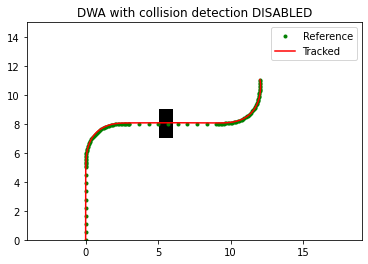

In [7]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g',label="Reference")
plt.plot(poses[:,0], poses[:,1], c='r',label="Tracked")
plt.title("DWA with collision detection DISABLED")
plt.legend()
plt.show()

Now it should be relatively straight-forward to integrate collision checking in the grid environment the robot is going to navigate

## Integrating Collision Check

In [8]:
start_pose = np.array([0, 0, np.pi/2])
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose)
ref_path = np.hstack([np.array(axis).reshape(-1,1) for axis in ref_path])

pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
failed_attempts = -1
while path_index < len(ref_path)-1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    if goal_threshold > np.min(np.hypot(local_ref_path[:,0]-pose[0],local_ref_path[:,1]-pose[1])) or failed_attempts > 20:
        failed_attempts = -1
        path_index = path_index + 1 + np.argmin(np.hypot(local_ref_path[:,0]-pose[0],local_ref_path[:,1]-pose[1]))
    failed_attempts += 1
    # get next command
    v, w = track(local_ref_path,pose,v,w,dt,detect_collision=True)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(pose, v,w, N=1, dt=dt)[0]

    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")


idx:1, v:0.050, w:0.000, time:17.9ms
idx:1, v:0.100, w:0.000, time:16.1ms
idx:1, v:0.150, w:0.060, time:20.3ms
idx:1, v:0.200, w:0.060, time:17.1ms
idx:1, v:0.250, w:0.060, time:17.9ms
idx:1, v:0.300, w:0.000, time:19.7ms
idx:1, v:0.350, w:0.000, time:23.7ms
idx:1, v:0.400, w:0.000, time:24.9ms
idx:1, v:0.450, w:0.000, time:26.2ms
idx:1, v:0.500, w:0.000, time:27.0ms
idx:2, v:0.550, w:0.000, time:30.7ms
idx:2, v:0.600, w:0.000, time:29.2ms
idx:2, v:0.650, w:0.000, time:30.4ms
idx:2, v:0.700, w:0.000, time:31.7ms
idx:2, v:0.750, w:0.000, time:31.7ms
idx:2, v:0.800, w:0.000, time:31.6ms
idx:2, v:0.850, w:0.000, time:31.7ms
idx:2, v:0.900, w:0.000, time:34.0ms
idx:3, v:0.950, w:0.000, time:32.2ms
idx:3, v:1.000, w:0.000, time:31.7ms
idx:3, v:1.050, w:0.000, time:31.6ms
idx:3, v:1.100, w:0.000, time:31.7ms
idx:3, v:1.150, w:0.000, time:31.7ms
idx:4, v:1.200, w:0.000, time:31.7ms
idx:4, v:1.200, w:0.000, time:34.5ms
idx:4, v:1.200, w:0.000, time:32.3ms
idx:4, v:1.200, w:0.000, time:31.7ms
i

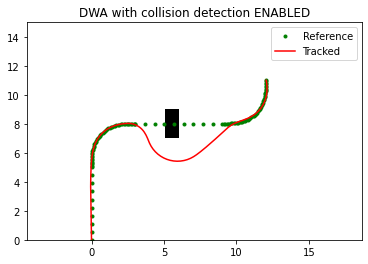

In [9]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g',label="Reference")
plt.plot(poses[:,0], poses[:,1], c='r',label="Tracked")
plt.title("DWA with collision detection ENABLED")
plt.legend()
plt.show()